## Description
This notebook plots fields (test loss, train loss) for different batch sizes on a given architecture.


In [237]:
import numpy as np
import glob
import argparse
import logging
import sys
import os
import matplotlib
import matplotlib.pyplot as plt

In [269]:
"""
UTILITIES FOR PARSING LOGS
"""
MAX_NUM_ITERATIONS = 10000000 # 40 epochs for 32 bS is 62k
LOG_PERIOD = 10
MAX_NUM_LINES = MAX_NUM_ITERATIONS // LOG_PERIOD # iterations / 10 since we store every 10 iterations
def parse_line(s):
    """
    Parse a line of the log file!
    """
    s = s[1:-2].strip().replace(' ','').replace('"','')
    fields = s.split(',')
    d = {}
    for field_val_pair in fields:
        k, v = field_val_pair.split(':')
        v = float(v)
        d[k] = v
    return d

def get_field_arr(dicts, field='test_acc', remove_zeros=True):
    """
    Get the values of a field through all iterations!
    """
    result = [0.]*len(dicts)
    for d in dicts:
        iteration = int(d['iteration'])
        field_val = d[field]
        result[iteration / 10] = field_val
    if remove_zeros:
        first_0 = result.index(0.0)
        return result[:min(MAX_NUM_LINES, first_0)]
    else:
        return result[:MAX_NUM_LINES]

def parse_batch_size(file_str):
    bs_ind = file_str.index('bs_')
    after_bs = file_str[bs_ind + 3:]
    batch_size = int(after_bs[:after_bs.index('_')])
    return batch_size

In [270]:
"""
EXPERIMENT PARAMETERS
"""
LOGDIR = './logs'
EXPERIMENT = 'baseline_resnet34_cifar10'
TITLE = 'ResNet34 on CIFAR10'

In [271]:
"""
PLOTTING PARAMETERS
"""
FIELDS_TO_PLOT = ['train_acc', 'test_acc']
PRETTY_FIELD_NAMES = {
    'train_loss': 'Train Loss',
    'test_loss': "Test Loss",
    'train_acc': "Train Accuracy",
    'test_acc': "Test Accuracy"
}

FIELD_LINETYPES = {
    'train_loss': '-',
    'test_loss': '--',
    'train_acc': '-',
    'test_acc': '--'
}

BS_COLORS = {
    128: '#884dc6',
    256: '#749b50',
    512: '#d35a95',
    1024: '#7192be', 
    2048: '#be6741',
    4096: '#6c3a60'
}

In [272]:
"""
*** RERUN THIS CELL TO LOAD LOG DATA ***
"""
results = {}


for field in FIELDS_TO_PLOT:
    results[field] = {}
    log_file_strs = glob.glob(os.path.join(LOGDIR, EXPERIMENT + '_*/log.txt'))
    assert len(log_file_strs) > 0, "Need to have logs to parse!"
    
    # get bs, log_file_for_bs tuples
    bs_log_file_pairs = sorted(list(map(lambda log_file_str: \
                    (parse_batch_size(log_file_str), log_file_str), log_file_strs)),
                    key=lambda x: x[0])

    for batch_size, log_file_str in bs_log_file_pairs:
        if not os.path.isfile(log_file_str):
            raise IOError('Log file not found! {}'.format(log_file_str))

        with open(log_file_str) as log_file:
            parsed_lines = list(map(parse_line, log_file.readlines()))
            field_values = get_field_arr(parsed_lines, field)
            results[field][batch_size] = field_values
    for batch_size, log_file_str in bs_log_file_pairs:
        results[field][batch_size] = results[field][batch_size][:len(results[field][32])]

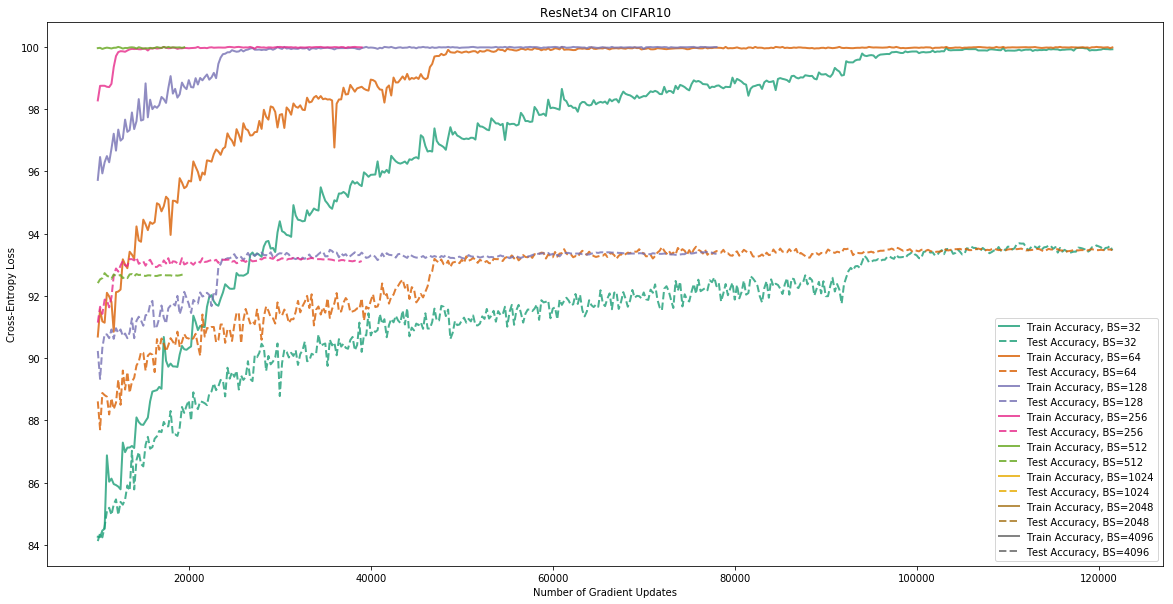

In [276]:
"""
PLOT ALL CURVES IN ONE FIGURE
"""
BEGIN = 1000
all_bs_values = results[FIELDS_TO_PLOT[0]].keys()
bs_int_values = sorted(list(map(int, all_bs_values)))

plt.figure(figsize=(20,10))

color_idx = np.linspace(.0, 1., len(all_bs_values))
for i, bs in zip(color_idx, bs_int_values):
    # ensure that field arrays are of save size here
    final_array_len = min([len(results[field][bs]) for field in FIELDS_TO_PLOT])
    for field in FIELDS_TO_PLOT:
        all_bs_values = results[field].keys()
        
        y_values = results[field][bs][BEGIN:final_array_len]
        x_values = [x*10 for x in range(BEGIN, len(y_values) + BEGIN)]
        label = "{0}, BS={1}".format(PRETTY_FIELD_NAMES[field], bs)
        plt.plot(x_values[::25], y_values[::25], alpha=.8, color=plt.cm.Dark2(i), \
                 linewidth=2, label=label, linestyle=FIELD_LINETYPES[field])
        plt.xlabel('Number of Gradient Updates')
        plt.ylabel('Cross-Entropy Loss')

plt.title(TITLE)
plt.legend(loc='lower right')
plt.plot()
plt.show()

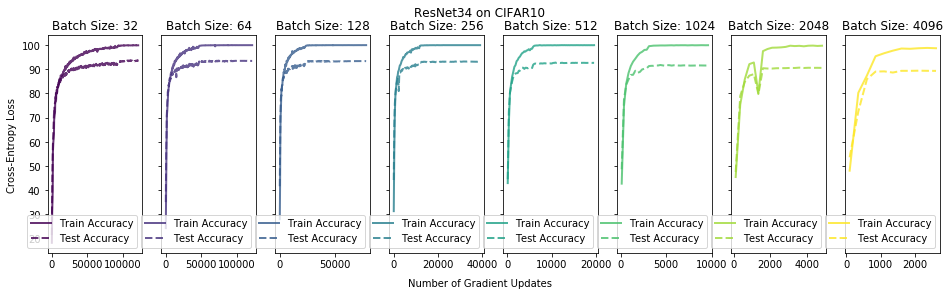

In [274]:
"""
PLOT ALL FIELDS WITH ONE FIGURE PER BATCH SIZE
"""
all_bs_values = results[FIELDS_TO_PLOT[0]].keys()
bs_int_values = sorted(list(map(int, all_bs_values)))

color_idx = np.linspace(.0, 1., len(all_bs_values))


f, axes = plt.subplots(1, len(bs_int_values), sharey=True)
f.set_figheight(4)
f.set_figwidth(16)
k = 0

for i, bs in zip(color_idx, bs_int_values):
    # ensure that field arrays are of save size here
    final_array_len = min([len(results[field][bs]) for field in FIELDS_TO_PLOT])
    for field in FIELDS_TO_PLOT:
        all_bs_values = results[field].keys()
        BEGIN = 10
        y_values = results[field][bs][BEGIN:final_array_len]
        x_values = [x*10 for x in range(BEGIN, len(y_values) + BEGIN)]
        label = PRETTY_FIELD_NAMES[field]
        
        plt.figure(i)
        axes[k].plot(x_values[::25], y_values[::25], alpha=.8, color=plt.cm.viridis(i), \
                 linewidth=2, label=label, linestyle=FIELD_LINETYPES[field])
        axes[k].set_title('Batch Size: {}'.format(bs))
        axes[k].legend(loc='lower right')
        #axes[k].set_xlabel('Number of Gradient Updates')
        #plt.ylabel('Loss')
    k += 1

f.suptitle(TITLE)
f.text(0.5, 0.01, 'Number of Gradient Updates', ha='center')
f.text(0.09, 0.5, 'Cross-Entropy Loss', va='center', rotation='vertical')

plt.show()

Details:
   - Network: ResNet34
   - Dataset: CIFAR-10
   - Plain SGD, no momentum/weight decay. LR=.1, decay factor of .2 every epoch. Changed original hyperparameters by removing momentum/weight decay.
   - Trained 100 epochs on all networks. Can retrain to get same total number of updates for all batch sizes
   - Going to rerun this on a language modeling task with an LSTM, as well as a different architecture on CIFAR10 (probably DenseNet)

train_acc
BS=32: 100.0
BS=64: 100.0
BS=128: 100.0
BS=256: 100.0
BS=512: 100.0
BS=1024: 100.0
BS=2048: 99.951171875
BS=4096: 98.9501953125
test_acc
BS=32: 93.74
BS=64: 93.6
BS=128: 93.51
BS=256: 93.29
BS=512: 92.87
BS=1024: 91.78
BS=2048: 90.81
BS=4096: 89.49


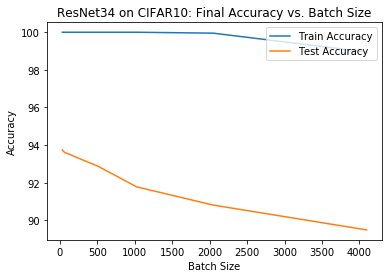

In [275]:
"""
PLOTTING FINAL TRAIN/TEST SCORE VS BATCH SIZE
"""
all_bs_values = results[FIELDS_TO_PLOT[0]].keys()
bs_int_values = sorted(list(map(int, all_bs_values)))

color_idx = np.linspace(.0, .9, len(all_bs_values))

#f, axes = plt.subplots(1, 1, sharey=True)
#f.set_figheight(4)
#f.set_figwidth(8)

for field in FIELDS_TO_PLOT:
    values = results[field]
    final_field_values = [max(values[bs]) for bs in bs_int_values]
    print(field)
    for bs, val in zip(bs_int_values, final_field_values):
        print("BS={0}: {1}".format(bs,val))
    label = PRETTY_FIELD_NAMES[field]
    plt.plot(bs_int_values, final_field_values, linestyle='-', label=label)

plt.title('{}: Final Accuracy vs. Batch Size'.format(TITLE))
plt.legend(loc='upper right')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')

plt.show()